In [1]:
import numpy as np

import matplotlib.pyplot as plt
import hyperobjects as ho
from pycapacity.algorithms import iterative_convex_hull_method
from pycapacity.objects import Polytope
from pycapacity.visual import plot_polytope
from common import *
from scipy.spatial import ConvexHull

q = np.pi / 4
A = np.array([
    [np.cos(q), -np.sin(q)],
    [np.sin(q), np.cos(q)]
])
print(A.T)
print(-A)
# A = A/np.linalg.norm(A, ord=2)
# print(np.linalg.det(A))

X = np.array([3,4])
Y = np.array([1,2])
print(Y.dot(A@X))
print(X.dot(A@Y))

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
[[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]
9.19238815542512
6.3639610306789285


In [14]:
J = np.random.uniform(-5,5,size=(3,7))

# print(np.linalg.pinv(J.T) == np.linalg.inv(J @ J.T))
print(np.linalg.pinv(J.T).round(2))
print((np.linalg.inv(J @ J.T) @ J).round(2))

print((np.linalg.inv(J @ J.T) @ J @ J.T))

[[-0.1  -0.   -0.   -0.05  0.05  0.06  0.03]
 [ 0.06  0.03  0.02  0.06  0.04  0.06  0.04]
 [ 0.06  0.09  0.11  0.   -0.03 -0.1  -0.09]]
[[-0.1  -0.   -0.   -0.05  0.05  0.06  0.03]
 [ 0.06  0.03  0.02  0.06  0.04  0.06  0.04]
 [ 0.06  0.09  0.11  0.   -0.03 -0.1  -0.09]]
[[ 1.00000000e+00 -1.38777878e-17  1.94289029e-16]
 [ 1.73472348e-17  1.00000000e+00  2.77555756e-17]
 [-1.59594560e-16 -2.77555756e-17  1.00000000e+00]]


In [20]:

def cube_edge_enumeration(n):
    """Returns edges in the cube"""
    # The direction is the first list, the position is the second
    e1 = [[0, 1], [0,0]]
    e2 = [[1, 0], [0,0]]
    e3 = [[0, 1], [1,0]]
    e4 = [[1, 0], [0,1]]

    # We start with the square
    Ed = [e1,e2,e3,e4]
    if n == 2:
        return Ed

    # The projection is simplified as a cube rotation followed by orthogonal projection
    # since dilations keep the combinatorics of the zonotope.
    N = np.eye(n)
    for d in range(3, N.shape[1]+1):
        N_ = N[:,:d]

        Ed_old = Ed
        Ed = []

        # Duplicate each edge in the new dimension and add the links
        for x in Ed_old:
            Ed.append([x[0] + [0], x[1] + [0]])
            Ed.append([x[0] + [0], x[1] + [1]]) # the duplicated and translated edge in the new dimension

        # Create links between
        check_if_already_added = set()
        for x in Ed_old:
            new_link1 = [[0 for _ in range(d-1)] + [1], [x+y for x,y in zip(x[1], x[0])] + [0]]
            new_link2 = [[0 for _ in range(d-1)] + [1], x[1] + [0]]

            t1 = tuple(new_link1[0] + new_link1[1])
            t2 = tuple(new_link2[0] + new_link2[1])
            if t1 not in check_if_already_added:
                check_if_already_added.add(t1)
                Ed.append(new_link1)
            if t2 not in check_if_already_added:
                check_if_already_added.add(t2)
                Ed.append(new_link2)
    return Ed

from numpy.core.umath_tests import inner1d

def ModHausdorffDist(A,B):
    #This function computes the Modified Hausdorff Distance (MHD) which is
    #proven to function better than the directed HD as per Dubuisson et al.
    #in the following work:
    #
    #M. P. Dubuisson and A. K. Jain. A Modified Hausdorff distance for object
    #matching. In ICPR94, pages A:566-568, Jerusalem, Israel, 1994.
    #http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=576361
    #
    #The function computed the forward and reverse distances and outputs the
    #maximum/minimum of both.
    #Optionally, the function can return forward and reverse distance.
    #
    #Format for calling function:
    #
    #[MHD,FHD,RHD] = ModHausdorffDist(A,B);
    #
    #where
    #MHD = Modified Hausdorff Distance.
    #FHD = Forward Hausdorff Distance: minimum distance from all points of B
    #      to a point in A, averaged for all A
    #RHD = Reverse Hausdorff Distance: minimum distance from all points of A
    #      to a point in B, averaged for all B
    #A -> Point set 1, [row as observations, and col as dimensions]
    #B -> Point set 2, [row as observations, and col as dimensions]
    #
    #No. of samples of each point set may be different but the dimension of
    #the points must be the same.
    #
    #Edward DongBo Cui Stanford University; 06/17/2014

    # Find pairwise distance
    D_mat = np.sqrt(inner1d(A,A)[np.newaxis].T + inner1d(B,B)-2*(np.dot(A,B.T)))
    # Calculating the forward HD: mean(min(each col))
    FHD = np.mean(np.min(D_mat,axis=1))
    # Calculating the reverse HD: mean(min(each row))
    RHD = np.mean(np.min(D_mat,axis=0))
    # Calculating mhd
    MHD = np.max(np.array([FHD, RHD]))
    return(MHD, FHD, RHD)

import scipy.optimize as opt
def fun(t, edge, K_kernel_orth_proj):
    D, p = edge
    vec = np.array(p)+t*np.array(D)
    return np.linalg.norm(K_kernel_orth_proj @ vec)

import numpy as np

def intersect_box(t_min, t_max, D):
    n = len(t_min)
    t_min_vals = np.zeros(n)
    t_max_vals = np.zeros(n)
    
    for i in range(n):
        if D[i] != 0:  # Avoid division by zero
            t_min_vals[i] = t_min[i] / D[i]
            t_max_vals[i] = t_max[i] / D[i]
        else:
            t_min_vals[i] = -np.inf  # No intersection in this dimension if D[i] is 0
            t_max_vals[i] = np.inf   # No intersection in this dimension if D[i] is 0
    
    # Sorting the intersections to find the valid range
    t_enter = np.maximum.reduce(np.minimum(t_min_vals, t_max_vals))
    t_exit = np.minimum.reduce(np.maximum(t_min_vals, t_max_vals))
    
    # Check if there is a valid intersection interval
    if t_enter > t_exit:
        return []  # No intersection points
    
    # Points of intersection
    intersection_points = []
    
    for t in [t_enter, t_exit]:
        point = t * D
        if np.all(point >= t_min) and np.all(point <= t_max):
            intersection_points.append(point)
    
    return intersection_points

# Example usage:
t_min = np.array([0, 0, 0])
t_max = np.array([1, 1, 1])
D = np.array([1, 0.5, 2])

intersection_points = intersect_box(t_min, t_max, D)
print("Intersection points:", intersection_points)


Intersection points: [array([0., 0., 0.]), array([0.5 , 0.25, 1.  ])]


In [24]:
p, n, m = 3,4,7

np.random.seed(20)
J = np.random.uniform(-1,1,size=(p,n))
N = np.random.uniform(-1,1,size=(n,m))
t_min = np.zeros(m)
t_max = np.random.uniform(500, 1200, size=m)
t_max = np.ones(m)
K = ~(ho.AffineMap(N@np.diag(t_max)).T(~ho.AffineSpace(J.T)))
# K = ho.AffineSpace(K.generators)
print(K.dim)

center_cube = np.linalg.pinv(N) @ N @ (0.5 * np.ones(m))
sphere_samples = (K.basis @ ho.sample_sphere(K.dim, 300000))

inter = []
for d in sphere_samples.T:
    inte = intersect_box(np.zeros(m), np.ones(m), d)
    # print(inte)
    if inte is not None:
        for x in inte:
            if np.all(x == t_min):
                pass
            else:
                inter.append(x)
inter = np.array(inter)
print(inter.shape)

# hull = ConvexHull((np.linalg.pinv(J.T) @ (N @ np.diag(t_max) @ inter.T)).T)
# my_vert = hull.points[hull.vertices]
# P_exp = Polytope(vertices=my_vert.T)

res = iterative_convex_hull_method(J.T, N, np.zeros(m), np.ones(m), tol=0.1)
P = Polytope(vertices=res[0])

res = iterative_convex_hull_method(K.generators, np.identity(m), 0*t_max, np.ones(m), tol=0.5)
print(res[-1].shape)
P2 = Polytope(vertices=np.linalg.pinv(J.T) @ N @ np.diag(t_max) @ res[-1])

6
(9070, 7)
(7, 132)


In [13]:
inter.shape

(11769, 7)

In [25]:
import numpy as np
from scipy.linalg import null_space

def sample_p_ball(n_samples, dimension, p):
    """Sample points uniformly within a p-ball in n dimensions."""
    points = np.random.randn(n_samples, dimension)
    norms = np.linalg.norm(points, ord=p, axis=1)
    scales = np.random.uniform(0, 1, n_samples) ** (1 / p)
    points = (points.T / norms).T * scales[:, None]
    return points

def project_onto_subspace(points, A):
    """Project points onto the subspace defined by A."""
    U, _, _ = np.linalg.svd(A, full_matrices=False)
    return points @ U @ U.T

def intersect_ball_with_subspace(center, radius, A, p=2, num_samples=1000):
    n = len(center)
    
    # Compute the null space of A
    null_space_matrix = null_space(A)
    
    if null_space_matrix.size == 0:
        raise ValueError("The subspace has no valid null space. Cannot project onto an empty subspace.")
    
    # Sample points on the unit p-ball
    ball_points = sample_p_ball(num_samples, n, p)
    
    # Translate ball to center at 'center'
    translated_points = center + ball_points
    
    # Project onto the subspace
    subspace_projection = project_onto_subspace(translated_points, null_space_matrix)
    
    # Filter points that lie within the p-ball of given radius
    norms = np.linalg.norm(subspace_projection - center, ord=p, axis=1)
    valid_points = subspace_projection[norms <= radius]

    return valid_points
# Example usage
t_min = np.array([0, 0, 0, 0, 0, 0, 0])
t_min = -np.ones(m)
t_max = np.ones(m)
A = np.array([
    [1, 2, 3, 0, 0.1, 0, 0],
    [0, 2, 0, 1, 1, -1, 0],
    [0, 0, 0, 0, 2, 3, 4]
])
A = (~K).basis.T
# b = np.array([1, 0, 2])
b = np.zeros(A.shape[0])

intersection_points = intersect_ball_with_subspace(np.ones(m)/2, 0.5, A, p=100, num_samples=500000)
print("Intersection points:", intersection_points.T.shape)

hull = ConvexHull((np.linalg.pinv(J.T) @ (N @ np.diag(t_max) @ intersection_points.T)).T)
my_vert = hull.points[hull.vertices]
P4 = Polytope(vertices=my_vert.T)


Intersection points: (7, 7402)


In [26]:
center_cube

array([0.37004211, 0.29145747, 0.24575249, 0.68021997, 0.23000737,
       0.70751083, 0.0870643 ])

In [27]:
# # (L & K).location.ravel() for L in Edges_
# for L in Edges_:
#     I = L & K
#     print(I.dim)
print(np.linalg.matrix_rank(inter))
print(K.dim)

6
6


Visual: no faces found, calculating faces
using provided 3d axis
Visual: no faces found, calculating faces
using provided 3d axis


<Axes3D: >

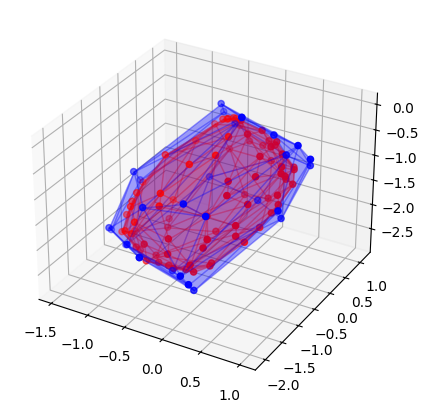

In [28]:
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

plot_polytope(P, plot=ax, color="blue", alpha=0.2)
# plot_polytope(P_exp, plot=ax, color="red", alpha=0.2)
# plot_polytope(P2, plot=ax, color="green", alpha=0.2)
plot_polytope(P4, plot=ax, color="red", alpha=0.2)